## Notebook to plot ACC Seizure Detection Plots

This notebook is focused solely on FBTC seizures.

A patient-specific approach will be tested

SET 2
- Training: BLIW_1, BLIW_2, YIVL_0, YIVL_1, AGGA_0, AGGA_1, AGGA_2, YWJN_5, YWJN_6 
- Testing: VNVW_1, WOSQ_2, AGGA_3, YIVL_2,  BLIW_3, YWJN_7

In [10]:
# import os
from datetime import datetime

# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from fast_ml.feature_selection import get_constant_features

from preepiseizures.src import Patient

## 1. Open data

In [2]:
data = pd.read_parquet('./data/features/all_patients_acc_features.parquet')

print(data.shape)

# remove columns with nans
data = data.dropna(axis=1)
print(data.shape)
data['patient'] = data['patient_seizure'].apply(lambda x: x.split('_')[0])
data['patient'].unique()

(87810, 1559)
(87810, 1557)


array(['AGGA', 'BLIW', 'VNVW', 'WOSQ', 'YIVL', 'YWJN'], dtype=object)

## 2. Train test split

In [133]:
training_set_keys = ['BLIW_0', 'BLIW_1', 'BLIW_2', 'YIVL_0', 'YIVL_1', 'AGGA_0', 'AGGA_1', 'AGGA_2', 'YWJN_4', 'YWJN_5', 'YWJN_6'] 
testing_set_keys = ['VNVW_0', 'VNVW_1', 'WOSQ_2', 'AGGA_3', 'YIVL_2',  'BLIW_3', 'YWJN_7']
all_training_set = data[data['patient_seizure'].isin(training_set_keys)].copy()
all_testing_set = data[data['patient_seizure'].isin(testing_set_keys)].copy()

In [134]:
features_cols = all_training_set.drop(columns=['patient_seizure', 'patient', 'timestamp', 'y']).columns

In [135]:
len(features_cols)


1554

### 2.2 Select patient data

In [330]:
patient = 'YWJN'
training_set = all_training_set[all_training_set['patient'] == patient].copy()
testing_set = all_testing_set[all_testing_set['patient'] == patient].copy()

train_seizures = training_set['patient_seizure'].unique()
test_seizures = testing_set['patient_seizure'].unique()
print(training_set.shape, testing_set.shape)

(6204, 1558) (1722, 1558)


In [331]:
testing_set

ACCM_Absolute energy  ACCM_Area under the curve  ACCM_Autocorrelation  \
86088            447.502166                   1.738535            447.502166   
86089            482.170295                   1.785712            482.170295   
86090            566.859854                   1.934880            566.859854   
86091            562.287664                   1.936220            562.287664   
86092            443.547722                   1.734120            443.547722   
...                     ...                        ...                   ...   
87805           2464.180598                   3.644963           2464.180598   
87806           3532.065662                   4.325519           3532.065662   
87807           2453.156790                   3.401446           2453.156790   
87808            812.330563                   2.129283            812.330563   
87809           2280.558930                   2.926332           2280.558930   

       ACCM_Average power  ACCM_Centroid  ACCM_ECDF Percentile Count_0  \
86088           44.750217       4.894972                        2000.0   
86089           48.217029       5.240058                        2000.0   
86090           56.685985       5.290182                        2000.0   
86091           56.228766       4.752158                        2000.0   
86092           44.354772       4.688063                        2000.0   
...                   ...            ...                           ...   
87805          246.418060       5.663177                        2000.0   
87806          353.206566       5.398936                        2000.0   
87807          245.315679       2.791245                        2000.0   
87808           81.233056       5.254661                        2000.0   
87809          228.055893       7.001859                        2000.0   

       ACCM_ECDF Percentile Count_1  ACCM_ECDF Percentile_0  \
86088                        8000.0                0.065260   
86089                        8000.0                0.062851   
86090                        8000.0                0.064179   
86091                        8000.0                0.065133   
86092                        8000.0                0.066288   
...                             ...                     ...   
87805                        8000.0                0.100486   
87806                        8000.0                0.113612   
87807                        8000.0                0.088133   
87808                        8000.0                0.067294   
87809                        8000.0                0.072946   

       ACCM_ECDF Percentile_1  ACCM_ECDF_0  ...  ACCZ_Wavelet variance_4  \
86088                0.275992       0.0001  ...             2.326713e-19   
86089                0.287786       0.0001  ...             9.608751e-20   
86090                0.308163       0.0001  ...             2.455554e-19   
86091                0.305386       0.0001  ...             3.428016e-20   
86092                0.268814       0.0001  ...             6.895001e-20   
...                       ...          ...  ...                      ...   
87805                0.564221       0.0001  ...             1.420763e-20   
87806                0.691312       0.0001  ...             4.535498e-06   
87807                0.496940       0.0001  ...             4.533857e-06   
87808                0.324314       0.0001  ...             4.535662e-06   
87809                0.407463       0.0001  ...             9.067716e-06   

       ACCZ_Wavelet variance_5  ACCZ_Wavelet variance_6  \
86088             3.372162e-19             4.637553e-19   
86089             1.399140e-19             1.941862e-19   
86090             3.569065e-19             4.919917e-19   
86091             5.516026e-20             8.546619e-20   
86092             1.043379e-19             1.511500e-19   
...                        ...                      ...   
87805             2.228913e-20             3.418428e-20   
87806          

### 2.3 Reform target labels

The current target labels consists on 0 for everything outside the seizure surrounding and 1 for 10 minutes before the seizure to 10 minutes after the seizure. 
This confounding region will be identified and removed from the training set.

In [332]:
patient_ = Patient.patient_class(patient)
patient_.get_seizure_annotations()
patient_.seizure_table

Crises       Data Hora Clínica       Localização lado  \
0  Crise 1 2020-01-07     14:14:30          temporal    E   
1  Crise 2 2020-01-07     19:21:58          sem alts   na   
2  Crise 3 2020-01-07     23:21:27          sem alts   na   
3  Crise 4 2020-01-08     18:50:21          sem alts   na   
4  Crise 5 2020-01-09     12:03:49  temporo-parietal    E   
5  Crise 6 2020-01-09     21:03:04          temporal    E   
6  Crise 7 2020-01-10     00:59:30          temporal    E   
7  Crise 8 2020-01-10     08:57:00          temporal    E   

  Focal / Generalisada Unnamed: 6  Unnamed: 7 Sono/ Vigília  \
0                    F        NaN         NaN       Vígilia   
1                F(ME)    Excluir         NaN       Vígilia   
2                F(ME)    Excluir         NaN       Vígilia   
3                F(ME)    Excluir         NaN       Vígilia   
4                 FBTC        NaN         NaN       Vígilia   
5                 FBTC        NaN         NaN       Vígilia   
6                 FBTC        NaN         NaN       Vígilia   
7                 FBTC        NaN         NaN       Vígilia   

                           Tipo Intervalo (10,10) onset no Bitalino  \
0                 Focal simples                                   0   
1                 Focal simples                            18:58:00   
2                 Focal simples                            19:26:00   
3                 Focal simples                            18:51:00   
4  Generalização Tónico-clónica                            00:00:00   
5  Generalização Tónico-clónica                            18:22:00   
6  Generalização Tónico-clónica                            19:12:00   
7  Generalização Tónico-clónica                                 NaN   

            Timestamp  
0 2020-01-07 14:14:30  
1 2020-01-07 19:21:58  
2 2020-01-07 23:21:27  
3 2020-01-08 18:50:21  
4 2020-01-09 12:03:49  
5 2020-01-09 21:03:04  
6 2020-01-10 00:59:30  
7 2020-01-10 08:57:00

In [333]:
seiz_surrounding_index = []

for seizure in patient_.seizure_table.index:

    onset = patient_.seizure_table.loc[seizure]['Timestamp']
    # preictal period is 10 minutes before seizure
    start = onset - pd.Timedelta(minutes=10)
    try:
        end_time = datetime.combine(onset.date(), patient_.seizure_table.loc[seizure, 'Fim'])
    except:
        end_time = onset + pd.Timedelta(minutes=2)
    seiz_surrounding_index += [training_set.loc[training_set['timestamp'].between(start, onset - pd.Timedelta(seconds=30))].index]
    posictal_0 = end_time
    posictal_1 = onset + pd.Timedelta(minutes=10)
    seiz_surrounding_index += [training_set.loc[training_set['timestamp'].between(posictal_0, posictal_1)].index]
    
seiz_surrounding_index = np.hstack(seiz_surrounding_index)                                               

In [334]:
training_set.drop(seiz_surrounding_index, inplace=True)

In [335]:
training_set['y_l'] = training_set['y'].apply(lambda x: 'seizure' if x == 1 else 'non-seizure')
fig= px.scatter(training_set, x='timestamp', y='ACCM_Absolute energy', color='y_l', color_continuous_scale='BuGn')
for seizure in patient_.seizure_table.index:
    fig.add_vline(x=patient_.seizure_table.loc[seizure]['Timestamp'], line_width=3, line_dash="dash", line_color="green")
fig.show()
training_set.drop(columns=['y_l'], inplace=True)

In [336]:
testing_set['y_l'] = testing_set['y'].apply(lambda x: 'seizure' if x == 1 else 'non-seizure')
fig= px.scatter(testing_set, x='timestamp', y='ACCM_Absolute energy', color='y_l', color_continuous_scale='BuGn')
for seizure in patient_.seizure_table.index:
    fig.add_vline(x=patient_.seizure_table.loc[seizure]['Timestamp'], line_width=3, line_dash="dash", line_color="green")
fig.show()
testing_set.drop(columns=['y_l'], inplace=True)

In [337]:
constant_features = get_constant_features(training_set[features_cols])
# print(constant_features)
exclude_cols = constant_features.Var
training_set.drop(columns=exclude_cols, inplace=True)
print('Number of features excluded: ', len(exclude_cols))
features_cols = training_set.drop(columns=['patient_seizure', 'patient', 'timestamp', 'y']).columns

Number of features excluded:  58


## 3. Features processing

### 3.2. Remove highly correlated features

In [338]:
corr_matrix = training_set[features_cols].corr().abs()
#corr_matrix.style.background_gradient(cmap='coolwarm')

In [339]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f'Dropping {len(to_drop)} features from {corr_matrix.shape[1]}.')

# Drop features 
#if to_drop[0] in training_set.columns:
#    training_set.drop(to_drop, axis=1, inplace=True)
new_training_set = training_set.drop(columns=to_drop)
new_testing_set = testing_set.drop(columns=to_drop)
features_cols = new_training_set.drop(columns=['patient_seizure', 'timestamp', 'y', 'patient']).columns

print('New shape: ', new_training_set.shape)
print(len(features_cols))

Dropping 1063 features from 1496.
New shape:  (5829, 437)
433


In [340]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(new_training_set[features_cols])
new_training_set[features_cols] = scaler.transform(new_training_set[features_cols])
new_testing_set[features_cols] = scaler.transform(new_testing_set[features_cols])

In [341]:
new_training_set

ACCM_Absolute energy  ACCM_Area under the curve  ACCM_Centroid  \
79884              0.000013                   0.003112       0.548255   
79885              0.000012                   0.002997       0.491053   
79886              0.000010                   0.002456       0.467823   
79887              0.000010                   0.002364       0.524176   
79888              0.000010                   0.002395       0.460651   
...                     ...                        ...            ...   
86083              0.000036                   0.006345       0.504333   
86084              0.000040                   0.006881       0.504224   
86085              0.000042                   0.007302       0.503018   
86086              0.000038                   0.006845       0.473993   
86087              0.000035                   0.006567       0.517107   

       ACCM_ECDF Percentile_0  ACCM_FFT mean coefficient_0  \
79884                0.004258                 1.161071e-06   
79885                0.004125                 6.715411e-07   
79886                0.002935                 6.977940e-07   
79887                0.002971                 1.613143e-06   
79888                0.003408                 8.911393e-07   
...                       ...                          ...   
86083                0.009037                 3.237633e-06   
86084                0.010098                 5.578132e-06   
86085                0.011906                 4.009963e-06   
86086                0.010660                 3.119958e-06   
86087                0.010236                 2.531815e-06   

       ACCM_FFT mean coefficient_1  ACCM_FFT mean coefficient_10  \
79884                     0.000001                      0.000019   
79885                     0.000001                      0.000014   
79886                     0.000002                      0.000008   
79887                     0.000002                      0.000016   
79888                     0.000002                      0.000015   
...                            ...                           ...   
86083                     0.000009                      0.000063   
86084                     0.000008                      0.000062   
86085                     0.000008                      0.000038   
86086                     0.000008                      0.000043   
86087                     0.000006                      0.000051   

       ACCM_FFT mean coefficient_100  ACCM_FFT mean coefficient_101  \
79884                       0.000038                       0.000058   
79885                       0.000036                       0.000049   
79886                       0.000032                       0.000036   
79887                       0.000047                       0.000038   
79888                       0.000058                       0.000051   
...                              ...                            ...   
86083                       0.000020                       0.000023   
86084                       0.000038                       0.000024   
86085                       0.000027                       0.000033   
86086                       0.000016                       0.000016   
86087                       0.000027                       0.000019   

       ACCM_FFT mean coefficient_102  ...  ACCZ_Spectral skewness  \
79884                       0.000049  ...                0.055169   
79885                       0.000047  ...                0.027996   
79886                       0.000038  ...                0.229762   
79887                       0.000027  ...                0.072843   
79888                       0.000032  ...                0.061551   
...                              ...  ...                     ...   
86083                       0.000021  ...                0.077343   
86084                       0.000028  ...                0.113666   
86085                       0.000025  ...                0.041773   
86086                    

In [342]:
fig = px.scatter(new_training_set, x='timestamp', y='ACCM_Absolute energy', color='patient_seizure')

fig.show()

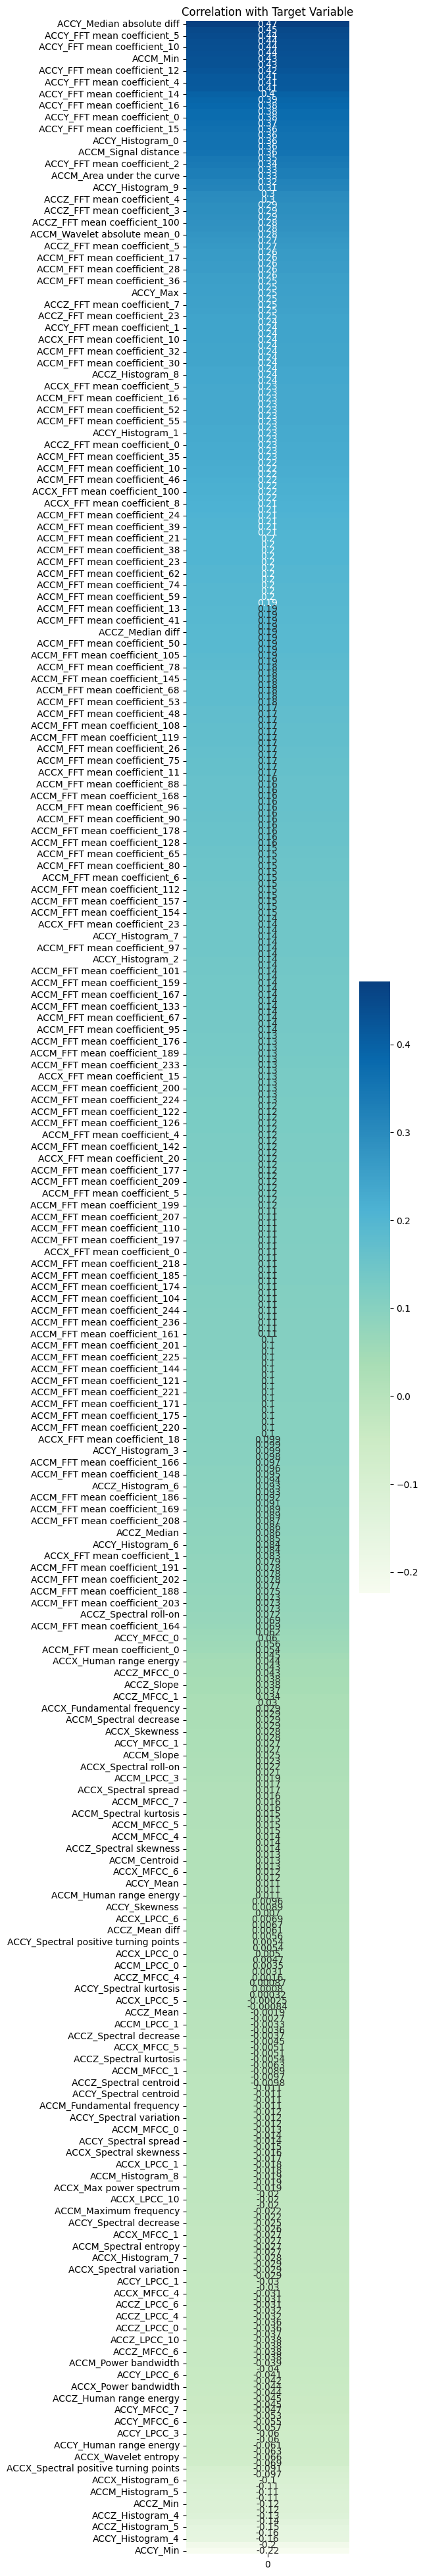

In [343]:
# Create a correlation matrix with target variable
target = new_training_set['y']
corr_with_target = new_training_set[features_cols].corrwith(target)

# Sort features by correlation with target variable
corr_with_target = corr_with_target.sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(4, 50))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

In [344]:
fig = px.scatter(new_training_set, y='ACCZ_Median', color=target)
fig.show()

In [345]:
X_train_ = new_training_set[features_cols].copy()
y_train_ = new_training_set['y'].copy()
X_test_ = new_testing_set[features_cols].copy()
y_test_ = new_testing_set['y'].copy()

In [346]:

from sklearn.feature_selection import SelectPercentile, f_classif


percentile = 2
selector_anova = SelectPercentile(score_func=f_classif, percentile=percentile)
X_train_ANOVA = selector_anova.fit_transform(X_train_, y_train_)
X_test_ANOVA = selector_anova.transform(X_test_)


feature_index = selector_anova.get_support(indices=True)
feature_names = X_train_.columns[feature_index]

# Convert selected features to DataFrame
features_anova_train1 = pd.DataFrame(X_train_ANOVA, columns=feature_names, index=X_train_.index)
features_anova_test1 = pd.DataFrame(X_test_ANOVA, columns=feature_names, index=X_test_.index)

print('Number of features selected: ', len(feature_names))

Number of features selected:  9


In [347]:
print(new_training_set['patient_seizure'].unique())

['YWJN_4' 'YWJN_5' 'YWJN_6']


In [362]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Split the data into training and testing sets

# Split the data into training and testing sets

training_set_keys = ['YWJN_4', 'YWJN_5']
validation_set_keys = ['YWJN_6']

X_train = features_anova_train1.loc[new_training_set.loc[new_training_set['patient_seizure'].isin(training_set_keys)].index]
y_train = y_train_.loc[new_training_set.loc[new_training_set['patient_seizure'].isin(training_set_keys)].index]
X_val = features_anova_train1.loc[new_training_set.loc[new_training_set['patient_seizure'].isin(validation_set_keys)].index]
y_val = y_train_.loc[new_training_set.loc[new_training_set['patient_seizure'].isin(validation_set_keys)].index]

# X_train, X_test, y_train, y_test = train_test_split(X_train_ANOVA, y_train_, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE for oversampling and NearMiss for undersampling
oversampler = SMOTE(sampling_strategy=0.5)  # Adjust the sampling strategy as needed
undersampler = NearMiss()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)
print(X_train_resampled.shape, y_train_resampled.shape)
# print number of samples in each class
print('Class 0: ', len(y_train_resampled[y_train_resampled == 0]))
print('Class 1: ', len(y_train_resampled[y_train_resampled == 1]))


# Define a list of classifiers to test
classifiers = [
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression())
]

best_model = None
# Train and evaluate each classifier
for name, classifier in classifiers:
    classifier.fit(X_train_resampled, y_train_resampled)
    y_pred = classifier.predict(X_val)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    # Print classification report and other metrics
    print(f"Classifier: {name}")
    # print(classification_report(y_test, y_pred))
    print(f"Recall: {np.round(100*recall, 2)}")
    print(f"Accuracy: {np.round(100*accuracy, 2)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred)}\n")

    if best_model is None:
        best_model = classifier
    else:
        if recall > recall_score(y_val, best_model.predict(X_val)):
            best_model = classifier
        elif recall == recall_score(y_val, best_model.predict(X_val)):
            if accuracy > accuracy_score(y_val, best_model.predict(X_val)):
                best_model = classifier
    
print('Best model: ', best_model)

(3030, 9) (3030,)
Class 0:  1515
Class 1:  1515
Classifier: Random Forest
Recall: 55.17
Accuracy: 81.76
Confusion Matrix:
[[2247  492]
 [  13   16]]

Classifier: SVM
Recall: 51.72
Accuracy: 93.03
Confusion Matrix:
[[2560  179]
 [  14   15]]

Classifier: Decision Tree
Recall: 62.07
Accuracy: 78.87
Confusion Matrix:
[[2165  574]
 [  11   18]]

Classifier: Logistic Regression
Recall: 51.72
Accuracy: 94.8
Confusion Matrix:
[[2609  130]
 [  14   15]]

Best model:  DecisionTreeClassifier()


In [363]:
def decision_layer(df, life):
    """
    Decision layer to detect a seizure
    :param df: dataframe with y_pred column, timestamp column and index
    :return: index of seizure
    """
    consecutive_preds = 0
    seizure_counter_dict = {}
    # all index of N consecutive 1s
    # add a median filter to smooth the prediction
    i = 0
    alarm = False
    
    while i < len(df):
        # in an alarm is raised
        if (consecutive_preds >= life and not alarm):
            # raise an alarm
            seizure_counter_dict[df['time'].iloc[i]] = i
            alarm = True
            # wait for 
            print('Seizure detected at index: ', i)
        else:
            if df['y_pred'].iloc[i] == 1:
                consecutive_preds += 1
            if df['y_pred'].iloc[i] == 0:
                consecutive_preds = 0
                alarm = False
        i += 1
    # after a consec_index wait for 2 minutes before the next prediction
    return seizure_counter_dict

In [364]:
y_pred = best_model.predict(X_val)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'], index=y_val.index)
y_pred_df['time'] = new_training_set.loc[y_pred_df.index, 'timestamp']
y_pred_df.sort_index(inplace=True)

# median filter to smooth the predictions
y_pred_df['y_pred'] = y_pred_df['y_pred'].rolling(30, center=True).median()

cc = decision_layer(y_pred_df, life=10)
cc

Seizure detected at index:  39
Seizure detected at index:  146
Seizure detected at index:  249
Seizure detected at index:  628
Seizure detected at index:  844
Seizure detected at index:  871
Seizure detected at index:  920
Seizure detected at index:  1080
Seizure detected at index:  1131
Seizure detected at index:  1331
Seizure detected at index:  2569


{Timestamp('2020-01-09 23:02:45'): 39,
 Timestamp('2020-01-09 23:20:55'): 146,
 Timestamp('2020-01-09 23:30:25'): 249,
 Timestamp('2020-01-10 00:07:25'): 628,
 Timestamp('2020-01-10 00:25:40'): 844,
 Timestamp('2020-01-10 00:28:37.667000'): 871,
 Timestamp('2020-01-10 00:33:15'): 920,
 Timestamp('2020-01-10 00:46:55'): 1080,
 Timestamp('2020-01-10 01:00:55'): 1131,
 Timestamp('2020-01-10 01:55:15'): 1331,
 Timestamp('2020-01-10 06:40:15'): 2569}

In [365]:
df_val = pd.DataFrame(y_val.values, columns=['y_true'], index=new_training_set.loc[y_val.index, 'timestamp'])

In [366]:
fig = px.line(df_val, y='y_true')

for seizure in patient_.seizure_table.index:
    fig.add_vline(x=patient_.seizure_table.loc[seizure]['Timestamp'], line_width=3, line_dash="dash", line_color="green")

for pred in cc:
    fig.add_vline(x=pred, line_width=3, line_dash="dash", line_color="red")

fig.show()

In [367]:
y_pred_test = classifier.predict(features_anova_test1)

y_pred_df_test = pd.DataFrame(y_pred_test, columns=['y_pred'], index=new_testing_set.index)
y_pred_df_test['time'] = new_testing_set['timestamp']

y_pred_df_test['y_pred'] = y_pred_df_test['y_pred'].rolling(30, center=True).median()


cc_test = decision_layer(y_pred_df_test, life=10)
cc_test

Seizure detected at index:  1399
Seizure detected at index:  1680


{Timestamp('2020-01-10 08:58:05'): 1399,
 Timestamp('2020-01-10 09:25:15'): 1680}

In [368]:
fig = px.line(new_testing_set, x='timestamp', y='y')
# fig.add_scatter(x=new_testing_set['timestamp'], y=y_pred_test)

for seizure in patient_.seizure_table.index:
    fig.add_vline(x=patient_.seizure_table.loc[seizure]['Timestamp'], line_width=3, line_dash="dash", line_color="green")

for pred in cc_test:
    fig.add_vline(x=pred, line_width=3, line_dash="dash", line_color="red")

fig.show()

In [369]:
len(cc_test)

2

In [357]:
print('FAR validation', (len(cc)-1)/((df_val.index[-1]-df_val.index[0]).total_seconds()/3600))
print('SD validation', 1)
print('FAR test', (len(cc_test)-1)/((y_pred_df_test.iloc[-1]['time']-y_pred_df_test.iloc[0]['time']).total_seconds()/3600))
print('SD test', 0)



FAR validation 0.3770291499389073
SD validation 1
FAR test 0.3934426229508197
SD test 0


# Anomaly Detection

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Generate synthetic data (replace with your dataset)
y = y_train_
# Split the data into training and testing sets
X_train = X_train_ANOVA.copy()
X_test = X_test_ANOVA.copy()
#X_train, X_test, y_train, y_test = train_test_split(X_train_ANOVA, y_train_, test_size=0.2, random_state=42)
model = 'IF' # 'IF' or 'SVM'

if model == 'IF':
    # Train the Isolation Forest on the normal class (majority class)
    anomaly_detector = IsolationForest(contamination=0.05)  # Adjust contamination as needed
    anomaly_detector.fit(X_train)
    # Set an anomaly score threshold
    threshold = -0.3  # Adjust as needed

if model == 'SVM':
    # Train the One-Class SVM on the normal class (majority class)
    anomaly_detector = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')  # Adjust parameters as needed
    anomaly_detector.fit(X_train)
    # Set an anomaly score threshold
    threshold = -158  # Adjust as needed

training_anomaly_scores = anomaly_detector.decision_function(X_train)
# Make predictions on the test data
anomaly_scores = anomaly_detector.decision_function(X_test)

## Trigger alarms for instances with anomaly scores below the threshold
#for i, score in enumerate(anomaly_scores):
#    if score < threshold:
#        # Trigger an alarm for instance i
#        print(f"Alarm triggered for instance {i} with score {score}")


In [ ]:
df_y = y_train_.copy()
y_train_df = pd.DataFrame(training_anomaly_scores, columns=['y_pred'], index=y_train_.index)
y_train_df['time'] = new_training_set.loc[y_train_df.index, 'timestamp']
y_train_df.sort_index(inplace=True)

fig = px.line(y_train_df, x='time', y='y_pred', color=df_y)
fig.show()

In [ ]:
df_y = y_test_.copy()
y_pred_df = pd.DataFrame(anomaly_scores, columns=['y_pred'], index=y_test_.index)
y_pred_df['time'] = new_testing_set.loc[y_pred_df.index, 'timestamp']
y_pred_df.sort_index(inplace=True)

fig = px.line(y_pred_df, x='time', y='y_pred', color=df_y)
fig.show()

In [ ]:
y_train_df

y_pred                       time
23038 -0.233125 2022-08-08 16:12:48.194146
23039 -0.233685 2022-08-08 16:12:48.783146
23040 -0.248399 2022-08-08 16:12:53.783146
23041 -0.217576 2022-08-08 16:12:58.783146
23042 -0.194264 2022-08-08 16:13:03.783146
...         ...                        ...
66659  0.016537 2022-08-10 17:34:13.783432
66660  0.002824 2022-08-10 17:34:18.783432
66661 -0.110525 2022-08-10 17:34:23.783432
66662 -0.223649 2022-08-10 17:34:28.783432
66663 -0.235932 2022-08-10 17:34:33.783432

[42996 rows x 2 columns]

In [ ]:
print('Information about this test')
print('Patient: ', patient_.id)
print('N 0 train:', len(y_train_[y_train_==0]), '  |  N 1 train:', len(y_train_[y_train_==1]), '  |  N 0 test:', len(y_test_[y_test_==0]), 'N 1 test:', len(y_test_[y_test_==1]))     
print('Seizure start: ', pd.Timedelta(seconds=30), ' | Seizure end: ', posictal_0 - onset)       
print('Number of features: ', X_train.shape[1])
print('Features names: ', features_anova_train1.columns)                                                


Information about this test
Patient:  YIVL
N 0 train: 42906   |  N 1 train: 90   |  N 0 test: 13220 N 1 test: 0
Seizure start:  0 days 00:00:30  | Seizure end:  0 days 00:02:00
Number of features:  8
Features names:  Index(['ACCM_Area under the curve', 'ACCM_ECDF Percentile_0', 'ACCM_Min',
       'ACCZ_FFT mean coefficient_5', 'ACCZ_FFT mean coefficient_6',
       'ACCZ_FFT mean coefficient_7', 'ACCZ_FFT mean coefficient_8',
       'ACCZ_Histogram_7'],
      dtype='object')


print(')

In [ ]:
print(train_seizures)

['YIVL_0' 'YIVL_1']


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

anomaly_df = pd.DataFrame({'score': training_anomaly_scores, 'label':y_train_}, index=y_train_.index)
# Load your dataset (anomaly scores as features and seizure labels)
data = anomaly_df.copy()

# Separate features (anomaly scores) and target (seizure labels)
X = data.drop('label', axis=1)
y = data['label']

# Split the data into training and testing sets
X_train = anomaly_df.loc[new_training_set.loc[new_training_set['patient_seizure']== patient_.id + '_1'].index].drop('label', axis=1)
y_train = anomaly_df.loc[new_training_set.loc[new_training_set['patient_seizure']== patient_.id + '_1'].index]['label']
X_test = anomaly_df.loc[new_training_set.loc[new_training_set['patient_seizure']== patient_.id + '_0'].index].drop('label', axis=1)
y_test = anomaly_df.loc[new_training_set.loc[new_training_set['patient_seizure']== patient_.id + '_0'].index]['label']


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize and train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Initialize and train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Evaluate the models on the testing set
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    print(f"{name} Model Evaluation:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
    print()

evaluate_model(lr_model, "Logistic Regression")
evaluate_model(rf_model, "Random Forest")
evaluate_model(gb_model, "Gradient Boosting")


/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Logistic Regression Model Evaluation:
Accuracy: 0.9990171668195519
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.7668235281257516
Confusion Matrix:
[[30494     0]
 [   30     0]]


Random Forest Model Evaluation:
Accuracy: 0.9968221727165509
Precision: 0.014492753623188406
Recall: 0.03333333333333333
F1 Score: 0.0202020202020202
ROC AUC: 0.6457199230449706
Confusion Matrix:
[[30426    68]
 [   29     1]]


Gradient Boosting Model Evaluation:
Accuracy: 0.9979360503210588
Precision: 0.02857142857142857
Recall: 0.03333333333333333
F1 Score: 0.030769230769230767
ROC AUC: 0.7197732887343958
Confusion Matrix:
[[30460    34]
 [   29     1]]




In [ ]:
anomaly_df_test = pd.DataFrame({'score': anomaly_scores}, index=y_test_.index)

y_pred = rf_model.predict_proba(anomaly_df_test)[:, 1]
anomaly_df_test['y_pred'] = y_pred
anomaly_df_test['time'] = y_pred_df['time']
fig = px.line(anomaly_df_test, x='time',y='y_pred')
fig.show()

In [ ]:
decision_layer(anomaly_df_test, life=1)

{}

In [34]:
patient_.seizure_table

Crises       Data Hora Clínica Localização lado Focal / Generalisada  \
0  Crise1 2022-08-10     01:08:44     FC e PO    L                 FBTC   
1  Crise2 2022-08-10     10:37:26     FC e PO    L                 FBTC   
2  Crise3 2022-08-11     01:36:30     FC e PO    L                 FBTC   

        Fim Sono/ Vigília                                Tipo  \
0  01:11:20          Sono  Hiperventilação e taquicardia e TC   
1  10:40:02         Sono?  Hiperventilação e taquicardia e TC   
2  01:39:06          Sono  Hiperventilação e taquicardia e TC   

            Timestamp  
0 2022-08-10 01:08:44  
1 2022-08-10 10:37:26  
2 2022-08-11 01:36:30